In [3]:
import genophenocorr
from genophenocorr.preprocessing import load_phenopacket_folder
from genophenocorr.preprocessing import configure_caching_cohort_creator
from genophenocorr.preprocessing import UniprotProteinMetadataService
from genophenocorr.preprocessing import VVTranscriptCoordinateService
from genophenocorr.preprocessing import UniprotProteinMetadataService
from genophenocorr.view import CohortViewable
from genophenocorr.view import ProteinVisualizable, ProteinVisualizer
from genophenocorr.model.genome import GRCh38

import hpotk
from IPython.display import display, HTML


store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release='v2023-10-09')
print(f'Loaded HPO v{hpo.version}')
print(f"Using genophenocorr version {genophenocorr.__version__}")

Loaded HPO v2023-10-09
Using genophenocorr version 0.1.1dev


In [10]:
WWOX_MANE_transcript = 'NM_016373.4'
WWOX_protein_id = "NP_057457.1"
cohort_creator = configure_caching_cohort_creator(hpo, timeout=20)
phenopacket_input_folder = "../../../../GIT/phenopacket-store/notebooks/WWOX/phenopackets"
cohort = load_phenopacket_folder(pp_directory=phenopacket_input_folder, cohort_creator=cohort_creator)

Patients Created:   0%|          | 0/34 [00:00<?, ?it/s]Expected a result but got an Error for variant: 16_78386858_78386858_A_AGCATAAAGCCAAGGTAGAAGCAATGACCCTGGACCTCGCTCTGCTCCGTAGCGTGCAGCATTTTGCTGAAGCATTCAAGGCCAAGAATGTGTGAGTGTTCCAGTGGAGGGTTATAGATCATAATTTCTTGCTATTGTAATATCTTTATCAGATGAACACAATTGGGAGAATGCAAGGCTGTTGTGTTGTCTTGGCGTCCAAACAGGAGGCTCATTTATATTGGCCCTGTTAAGGTGAACCGTATTTTCTTGACTCACAGTCACCTTCATTATGAGATGTGTCATCAATCTAATAACAGCTTCCCACATACCAAAAGAGAAGACACTATTAAAGCACTAGTAAAAGTGGCTAATAAAAGCTTGGCAATAGTAAGATGCATCCTGATTATAAGATTTTTTGTAGTGCATTTCAGAATGGAGTAAGAGTATATTTAAATTGCATTCAGGAACAAGTAAACTCAGTTATCCAGTATGGCAGGGAGGTTGACAATCCAAGCACCCAAAAGACCTCTAGTTTCTAAAGCCTTCGATGATTTGATGTGGTACATGGATGTGGTTCCAAAAAACATGGACTCACATTCCTTTTATTTATTTTTTTTCATCCTTTTCAGTCTTTCAAAATTCCAGTTGGAGAAAGCCTTAGTTAGGGCCTAGCATATTTTGATCCTATCATATGCTAGCATCCCTTTCTAACAGAGAAGGTTGTAGGAGAAAGGGAGAGAAGCGGAAGGGGGTGGGGAGACAGAGAGACAGACAGGAGGCCTCAAACCCTGAAACACTGAGCTAAGGAAAGTGATCATGGCAAGCTACACTAATTACAATACTTTGTTTCCAAGTGTTTATTTTTACTCATATTTAGGGCAGGCAATCCTG

In [11]:
viewer = CohortViewable(hpo=hpo)
html = viewer.process(cohort=cohort, transcript_id=WWOX_MANE_transcript)
display(HTML(html))

HPO Term,ID,Annotation Count
Global developmental delay,HP:0001263,34
EEG abnormality,HP:0002353,29
Epileptic encephalopathy,HP:0200134,28
Hypokinesia,HP:0002375,20
Reduced eye contact,HP:0000817,19
Thin corpus callosum,HP:0033725,17
Spasticity,HP:0001257,15
Cerebral atrophy,HP:0002059,14
Bilateral tonic-clonic seizure,HP:0002069,11
Axial hypotonia,HP:0008936,10


<Axes: title={'center': 'WW domain-containing oxidoreductase\ntranscript: NM_016373.4, protein: NP_057457.1'}>

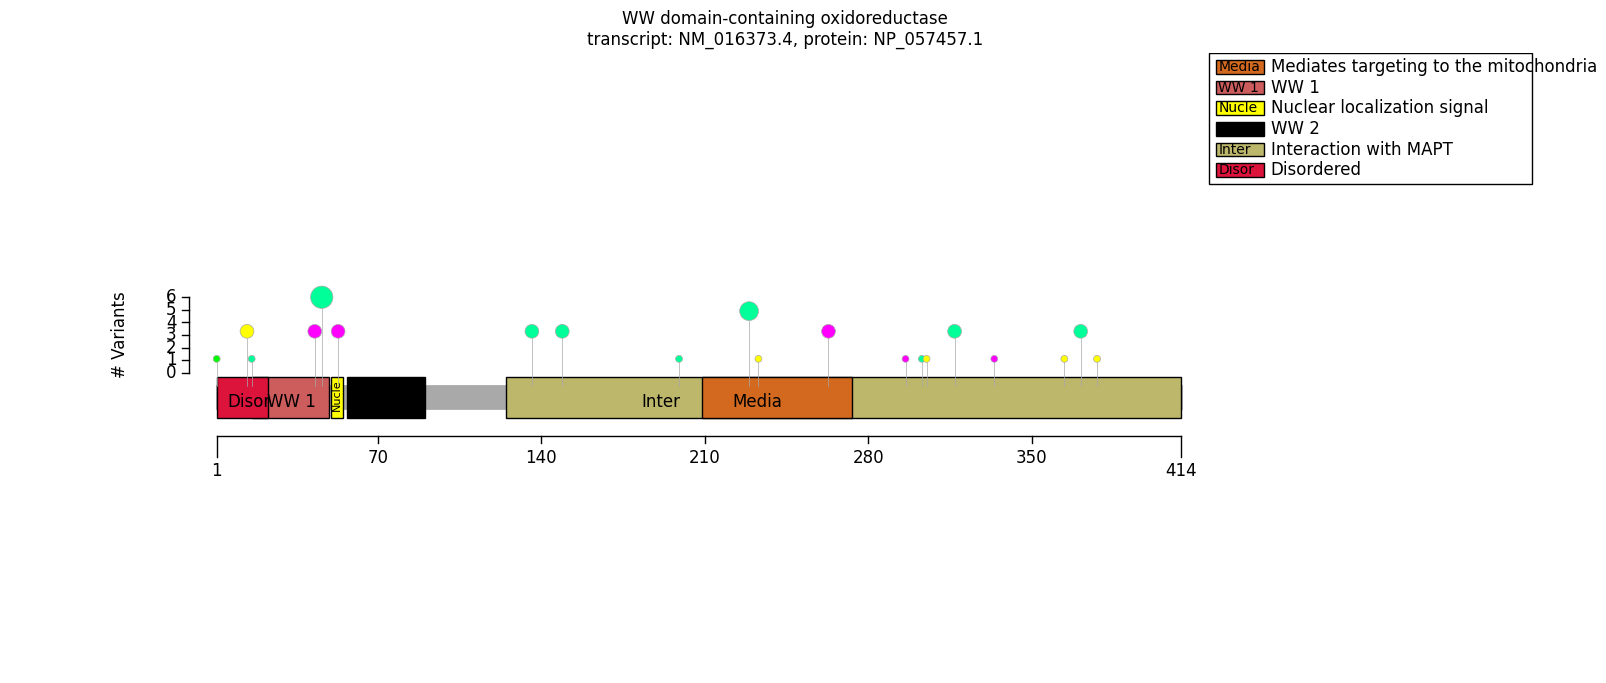

In [12]:
txc_service = VVTranscriptCoordinateService(genome_build=GRCh38)
tx_coordinates = txc_service.fetch(WWOX_MANE_transcript)
pms = UniprotProteinMetadataService()
protein_meta = pms.annotate(WWOX_protein_id)


pvis = ProteinVisualizable(tx_coordinates=tx_coordinates, protein_meta=protein_meta, cohort=cohort)
drawer = ProteinVisualizer()
drawer.draw_fig(pvis=pvis)

In [13]:
from genophenocorr.analysis import configure_cohort_analysis, CohortAnalysisConfiguration
from genophenocorr.model import VariantEffect
from genophenocorr.analysis.predicate import PatientCategories

config = CohortAnalysisConfiguration()
config.pval_correction = 'fdr_bh'
config.heuristic_strategy(threshold_HPO_observed_frequency=0.5)
analysis = configure_cohort_analysis(cohort, hpo, config=config)

In [16]:
fs = analysis.compare_by_variant_effect(VariantEffect.FRAMESHIFT_VARIANT, tx_id=WWOX_MANE_transcript)
fs.summarize(hpo, category=PatientCategories.YES)

FRAMESHIFT_VARIANT on NM_016373.4   Yes             No                    \
                                  Count Percent  Count Percent   p value   
Hyperreflexia [HP:0001347]          0/2      0%    5/5    100%  0.047619   
Thin corpus callosum [HP:0033725]   3/7     43%  13/17     76%  0.167048   
Ataxia [HP:0001251]                 0/2      0%    6/9     67%  0.181818   
Cerebral atrophy [HP:0002059]       2/7     29%  12/20     60%  0.208696   
Reduced eye contact [HP:0000817]    4/7     57%  14/17     82%  0.306844   
Spasticity [HP:0001257]             3/5     60%  12/15     80%  0.559791   
Axial hypotonia [HP:0008936]        3/6     50%    6/8     75%  0.580420   
Hypokinesia [HP:0002375]            5/7     71%  14/17     82%  0.608037   

FRAMESHIFT_VARIANT on NM_016373.4                    
                                  Corrected p value  
Hyperreflexia [HP:0001347]                 0.380952  
Thin corpus callosum [HP:0033725]          0.417391  
Ataxia [HP:0001251]                        0.417391  
Cerebral atrophy [HP:0002059]              0.417391  
Reduced eye contact [HP:0000817]           0.490951  
Spasticity [HP:0001257]                    0.608037  
Axial hypotonia [HP:0008936]               0.608037  
Hypokinesia [HP:0002375]                   0.608037